# DeepXDE - Bernard Cavity - Data + Physics case

In this notebook i'll be implementing the bernard cavity case, but this time using a hybrid approach for training, which means: i'll be using a physics loss and a data loss. I'll be using as base the equations and top performing model reported in Hashemi+2024, added with some hard constraints.

In [7]:
# stdlib imports
import os
from functools import reduce

# Setting deepxde backend before importing deepxde
os.environ["DDE_BACKEND"] = "pytorch"

import deepxde as dde
import torch
import numpy as np
import fluidfoam as ff

import matplotlib.pyplot as plt

# Problem constants

In [3]:
rho = 1
mu = 0.001
alpha = 0.005
D = 0.1
L = D
beta = 1.0
g = 9.81

T0 = 0
T_bottom = 1

S0 = (T0 - T0)/(T_bottom - T0)
S_bottom = (T_bottom - T0)/(T_bottom - T0)


assert T_bottom > T0, "For a Benard cell the bottom temperature should be higher than the rest"

Ra = g*beta*(T_bottom-T0)*D**3*rho/(alpha*mu)
Pr = mu/(rho*alpha)
print(f"{Ra = }, {Pr = }")

Ra = 1962.0000000000005, Pr = 0.2


# Loading data

In [8]:
CASE = "../../tests/vizualizing_simulation_data/bernard_cell_of_v2/"

x, y, z = ff.readmesh(CASE, structured=True)

u, v, w = ff.readvector(CASE, "1000", "U", structured=True)
p = ff.readscalar(CASE, "1000", "p", structured=True)
T = ff.readscalar(CASE, "1000", "T", structured=True)

N = reduce(lambda l, r: l*r, x.shape)

N

Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/owner
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/faces
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/points
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/neighbour
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2/1000/U
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/owner
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/faces
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/points
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/neighbour
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2/1000/p
Reading file ../../tests/vizualizing_simulation_data/ber

40000

In [17]:
X = np.hstack([x.reshape(N, 1), y.reshape(N, 1)], dtype=np.float32)
Y = np.hstack([f.reshape(N, 1) for f in (u, v, p, T)], dtype=np.float32)

X

array([[ 4.71725e-08, -4.92472e-08,  0.00000e+00,  3.00982e+02],
       [-4.34379e-09,  4.59052e-08, -1.72281e-04,  3.00947e+02],
       [-5.98722e-08,  4.46158e-07, -5.17773e-04,  3.00912e+02],
       ...,
       [ 7.42900e-12, -3.84690e-11, -8.81060e-01,  3.00000e+02],
       [ 3.28380e-11, -1.01437e-10, -8.85965e-01,  3.00000e+02],
       [ 4.35610e-11, -4.35720e-11, -8.90870e-01,  3.00000e+02]],
      shape=(40000, 4), dtype=float32)

In [11]:
Y

array([[ 4.71725e-08, -4.92472e-08,  0.00000e+00,  3.00982e+02],
       [-4.34379e-09,  4.59052e-08, -1.72281e-04,  3.00947e+02],
       [-5.98722e-08,  4.46158e-07, -5.17773e-04,  3.00912e+02],
       ...,
       [ 7.42900e-12, -3.84690e-11, -8.81060e-01,  3.00000e+02],
       [ 3.28380e-11, -1.01437e-10, -8.85965e-01,  3.00000e+02],
       [ 4.35610e-11, -4.35720e-11, -8.90870e-01,  3.00000e+02]],
      shape=(40000, 4), dtype=float32)

# Model definition

In [45]:
# Define geometry

## Let's go with a square for this case
geom = dde.geometry.Rectangle(xmin=(0, 0), xmax=(1, 1))

# Define boundaries and boundary conditions
def boundary_top(X,on_boundary):
    on = np.logical_and(dde.utils.isclose(X[1], 1),on_boundary)
    return on


def boundary_bottom(X,on_boundary):
    on = np.logical_and(dde.utils.isclose(X[1], 0),on_boundary)
    return on

def boundary_sides(X,on_boundary):
    on = ~boundary_bottom(X, on_boundary) and ~boundary_top(X, on_boundary) and on_boundary
    return on

def boundary_walls(X,on_boundary):
    return on_boundary


## Here we will have 2 dirichlet conditions on the speed components and one in the pressure 

bc_wall_u = dde.DirichletBC(geom, lambda x: 0, boundary_walls, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda x: 0, boundary_walls, component=1)

bc_top_T    = dde.DirichletBC(geom, lambda x: S0      , boundary_top, component=3)
bc_bottom_T = dde.DirichletBC(geom, lambda x: S_bottom, boundary_bottom, component=3)
bc_sides_T  = dde.NeumannBC(geom,   lambda x: 0       , boundary_sides, component=3)


def pde_nondimensional(X,Y):
    """Nondimensional Boussinesq approximated NS equations"""
    
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    
    dT_x = dde.grad.jacobian(Y, X, i=3, j=0)
    dT_y = dde.grad.jacobian(Y, X, i=3, j=1)
    
    dT_xx = dde.grad.hessian(Y, X, component=3, i=0, j=0)
    dT_yy = dde.grad.hessian(Y, X, component=3, i=1, j=1)

    pde_cont   = du_x + dv_y
    pde_u      = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + dp_x - (Pr/Ra)**0.5*(du_xx+ du_yy)
    pde_v      = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + dp_y - (Pr/Ra)**0.5*(dv_xx+ dv_yy) - Y[:, 3:]
    pde_energy = Y[:,0:1]*dT_x +  Y[:,1:2]*dT_y - (dT_xx + dT_yy)/(Pr*Ra)**0.5

    
    return [pde_u, pde_v, pde_cont, pde_energy]

def non_dimensionalise_input(X):
    return X/D

def transform(X, Y):
    """Ansatz to make the spped exactly zero on the boundaries"""
    noslip_ansatz_factor = X[:, 0:1] * (L - X[:, 0:1]) * X[:, 1:2] * (D - X[:, 1:2])
    temperature_ansatz = X[:, 1:2]/D*(S0 + (D - X[:, 1:2])) + S_bottom * (D - X[:, 1:2])/D

    return torch.hstack(
        (
            noslip_ansatz_factor*Y[:, 0:2],  
            1.0 + (X[:, 0:1]**2 + X[:, 1:2]**2)**0.5*Y[:, 2:3],
            temperature_ansatz +  X[:, 1:2] * (D - X[:, 1:2])*Y[:, 3:]
        )
    )


# Define model

net = dde.maps.FNN([2,] + [512]*6 + [4,], "silu", "Glorot uniform")

HARD_NOSLIP = True

if HARD_NOSLIP:
    bcs = [bc_sides_T]
    net.apply_output_transform(transform)
else:
    bcs = [bc_wall_u, bc_wall_v, bc_top_T, bc_bottom_T, bc_sides_T]

    

data = dde.data.PDE(
    geom,
    pde_nondimensional,
    bcs,
    num_domain=1024,
    num_boundary=256,
    num_test=100,
    # anchors=X,
    # solution=Y
)

model = dde.Model(data, net)

In [26]:
class ReferencePointResampler(dde.callbacks.PDEPointResampler):
    def __init__(self, period, ref_point, **kwargs):
        super().__init__(period, bc_points=True, **kwargs)
        self.ref_point = ref_point

    
    def on_train_begin(self):
        """Add the desired reference point in the beginning of the trainining"""
        super().on_train_begin()
        bc_points = self.model.data.train_x_bc
        self.model.data.train_x_bc = np.vstack([bc_points, self.ref_point])
        

    def on_epoch_end(self):
        """
        Modification of parent method that add the reference point 
        after each resample if boundary points are being resampled.
        """

        self.epochs_since_last_resample = self.period

        act = self.epochs_since_last_resample == self.period
        
        super().on_epoch_end()
        
        # Append the reference point to BC points
        if self.bc_points and act:
            bc_points = self.model.data.train_x_bc
            self.model.data.train_x_bc = np.vstack([bc_points, self.ref_point])




In [46]:
data = dde.data.PDE(
    geom,
    pde_nondimensional,
    bcs,
    num_domain=1024,
    num_boundary=256,
    num_test=100
)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)

Compiling model...
'compile' took 0.000139 s



In [28]:
resampler = ReferencePointResampler(period=100, ref_point=np.array([0, 0]))

checkpointer = dde.callbacks.ModelCheckpoint(
    filepath="model.ckpt",  # prefix and path for saved model files
    verbose=1,                           # print saving messages
    save_better_only=True,              # save every period or only if improved
    period=5_000,                       # save every epoch; set to e.g. 10 to save every 10 epochs
    monitor="train loss"                # metric to monitor, "train loss" or "test loss"
)

In [51]:
# Train model

#1st stage - ADAM optimizer
adam = torch.optim.Adam(net.parameters(), lr=0.001, betas=[0.9, 0.999])

model.compile(optimizer=adam)
losshistory_1, train_state_1 = model.train(iterations=147_000, callbacks=[resampler, checkpointer])

# 2nd stage - L-BFGS optimizer 
model.compile("L-BFGS")
dde.optimizers.config.set_LBFGS_options(ftol=1e-12, gtol=1e-12)
losshistory_2, train_state_2 = model.train(iterations=3_000, callbacks=[resampler, checkpointer])

Compiling model...
'compile' took 0.001603 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
48471     [2.45e-07, 1.76e-07, 3.37e-08, 8.89e-08, 1.74e-08]    [1.08e-07, 1.01e-07, 3.13e-08, 7.05e-08, 1.74e-08]    []  
49000     [5.30e-07, 7.53e-07, 1.07e-07, 4.44e-07, 5.64e-08]    [2.65e-07, 3.92e-07, 7.88e-08, 3.60e-07, 5.64e-08]    []  
50000     [4.17e-07, 5.58e-07, 5.85e-08, 3.09e-07, 2.64e-08]    [2.24e-07, 2.35e-07, 5.43e-08, 2.62e-07, 2.64e-08]    []  
Epoch 50835: train loss improved from 4.75e-05 to 1.37e-06, saving model to model.ckpt-50835.pt ...

51000     [1.10e-05, 8.51e-05, 1.79e-05, 5.13e-06, 3.21e-07]    [7.23e-06, 7.77e-05, 1.22e-05, 3.24e-06, 3.21e-07]    []  
52000     [1.32e-05, 2.04e-05, 8.40e-07, 2.77e-06, 4.60e-08]    [1.20e-05, 1.46e-05, 6.97e-07, 1.76e-06, 4.60e-08]    []  
53000     [1.38e-06, 1.38e-05, 2.16e-05, 1.14e-04, 6.04e-08]    [1.21e-06, 1.20e-05, 1.41

In [ ]:
# model.restore("path/to/model.ckpt-xxx", verbose=1)

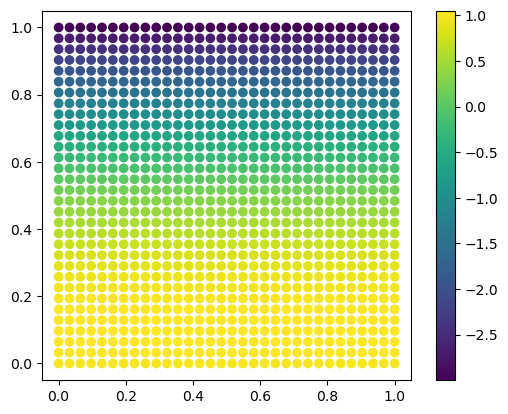

In [52]:
samples = geom.uniform_points(1000)
res = model.predict(samples) 

x, y = samples.T
u, v, p, T = res.T

plt.scatter(x, y, c=p)
plt.colorbar()

plt.gca().set_aspect("equal")

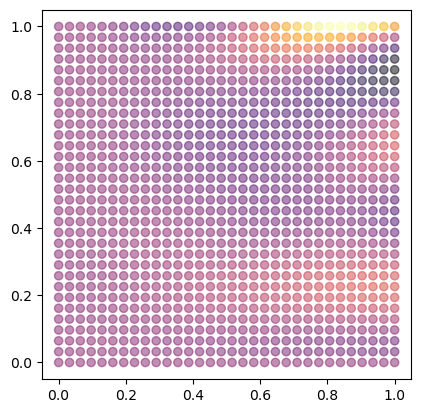

In [53]:

V = np.sqrt(v**2 + u**2)
plt.scatter(x, y, c=v, alpha=0.5, cmap="inferno")

plt.gca().set_aspect("equal")

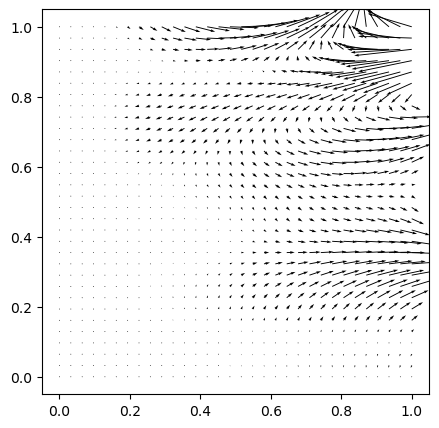

In [54]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(x, y, u, v)
# plt.gca().set_aspect("equal")

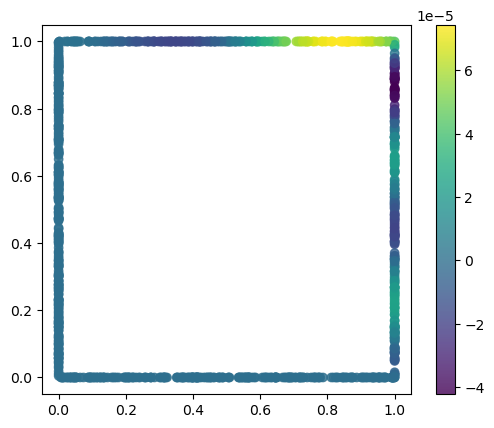

In [55]:
samples = geom.random_boundary_points(1000)
res = model.predict(samples)

x, y = samples.T
u, v, p, T = res.T

V = np.sqrt(v**2 + u**2)
plt.scatter(x, y, c=v, alpha=0.8)

plt.colorbar()
plt.gca().set_aspect("equal")

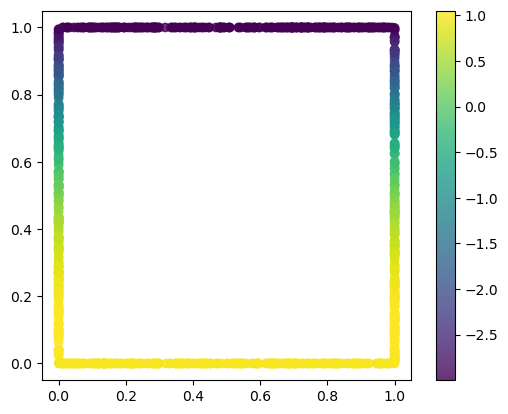

In [56]:
samples = geom.random_boundary_points(1000)
res = model.predict(samples)

x, y = samples.T
u, v, p, T = res.T

plt.scatter(x, y, c=p, alpha=0.8)

plt.colorbar()

plt.gca().set_aspect("equal")

In [ ]:
du_x = dde.grad.jacobian(Y, X, i=0, j=0)
du_y = dde.grad.jacobian(Y, X, i=0, j=1)